In [95]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features
import serial
from matplotlib import cm
import subprocess


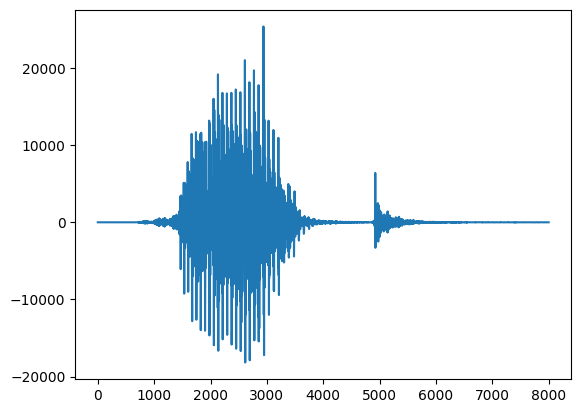

In [109]:
# Dataset path and view possible targets
# filename  = '../data_speech_commands_v0.02/four/0a2b400e_nohash_0.wav'  #Four
filename  = '../data_speech_commands_v0.02/right/0a2b400e_nohash_3.wav' #Right
# filename  = '../data_speech_commands_v0.02/stop/0a196374_nohash_0.wav'  #Stop

signal, fs = librosa.load(filename, sr=8000)
signal=signal*(2**15)
function=signal.astype(np.int16)
np.savetxt('time_series_1s.dat', function, fmt='%d', delimiter='\n')


plt.plot(signal)

In [97]:
subprocess.run("cd ../ ; pio run -t upload", shell=True)

ser = serial.Serial()
ser.baudrate = 115200
ser.port = '/dev/cu.usbserial-14210'
ser.open()

for i in range(20):            # 256 = 16*16
    b = ser.readline()          # read a byte string
    str_rn = b.decode()
    str_input = str_rn.rstrip()
    print(f"{i}  : {str_input}")
    if str_input == "Setup done":
        break

ser.close()

********************************************************************************
Obsolete PIO Core v6.1.7 is used (previous was 6.1.9)
Please remove multiple PIO Cores from a system:
https://docs.platformio.org/en/latest/core/installation/troubleshooting.html
********************************************************************************
Processing featheresp32 (platform: espressif32; board: featheresp32; framework: arduino)
--------------------------------------------------------------------------------
Verbose mode can be enabled via `-v, --verbose` option
CONFIGURATION: https://docs.platformio.org/page/boards/espressif32/featheresp32.html
PLATFORM: Espressif 32 (6.3.1) > Adafruit ESP32 Feather
HARDWARE: ESP32 240MHz, 320KB RAM, 4MB Flash
DEBUG: Current (cmsis-dap) External (cmsis-dap, esp-bridge, esp-prog, iot-bus-jtag, jlink, minimodule, olimex-arm-usb-ocd, olimex-arm-usb-ocd-h, olimex-arm-usb-tiny-h, olimex-jtag-tiny, tumpa)
PACKAGES: 
 - framework-arduinoespressif32 @ 3.20009.0 

In [110]:
a= function
a= a.astype(np.int16)
# a= a.astype(np.int32)


ser = serial.Serial()
ser.baudrate = 115200
ser.port = '/dev/cu.usbserial-14210'
ser.open()

for i in range(len(a)):
    values = str(a[i])
    send=bytearray(values, encoding='utf8')
    jumpline=bytearray('\n', encoding='utf8')
    ser.write(send)
    ser.write(jumpline)
    # print(f"send   [{i}]  : {send}")
    
data = []                       # empty list to store the data
for i in range(256):            # 256 = 16*16
    b = ser.readline()          # read a byte string
    str_rn = b.decode()
    str_input = str_rn.rstrip()
    data.append(str_input)
    print(f"{i}  : {str_input}")
    
    
mfcc=np.array(data)
# mfcc=mfcc.astype(np.int16)
mfcc=mfcc.astype(np.float16)

    


ser.close()
print(len(mfcc))

0  : 48.30
1  : 2.83
2  : 0.49
3  : -0.01
4  : -0.63
5  : -0.48
6  : -0.00
7  : -0.17
8  : -0.20
9  : 0.11
10  : 0.02
11  : 0.27
12  : 0.16
13  : 0.14
14  : -0.29
15  : -0.31
16  : 63.76
17  : 0.43
18  : -5.19
19  : 2.16
20  : 2.03
21  : -0.97
22  : -1.58
23  : -0.28
24  : 1.62
25  : 0.69
26  : -1.69
27  : 0.29
28  : 1.65
29  : -0.50
30  : -0.49
31  : 0.21
32  : 87.28
33  : 0.13
34  : -9.84
35  : 1.98
36  : 1.16
37  : -0.88
38  : -4.34
39  : 1.38
40  : 0.66
41  : 0.75
42  : -0.83
43  : -1.60
44  : 1.57
45  : -0.12
46  : -0.11
47  : 0.08
48  : 120.91
49  : 13.59
50  : -5.36
51  : 0.30
52  : -0.06
53  : -2.99
54  : -1.42
55  : 1.75
56  : 0.36
57  : 1.48
58  : -0.19
59  : -0.63
60  : 1.34
61  : -0.01
62  : -0.40
63  : 0.13
64  : 140.23
65  : 8.08
66  : -2.93
67  : -1.56
68  : -1.71
69  : -0.97
70  : -0.75
71  : 1.47
72  : 0.46
73  : 1.02
74  : -1.71
75  : 0.15
76  : 0.38
77  : -0.57
78  : -0.47
79  : -0.11
80  : 144.48
81  : 4.41
82  : -1.87
83  : -3.36
84  : -0.28
85  : 0.46
86  : 0.01
8

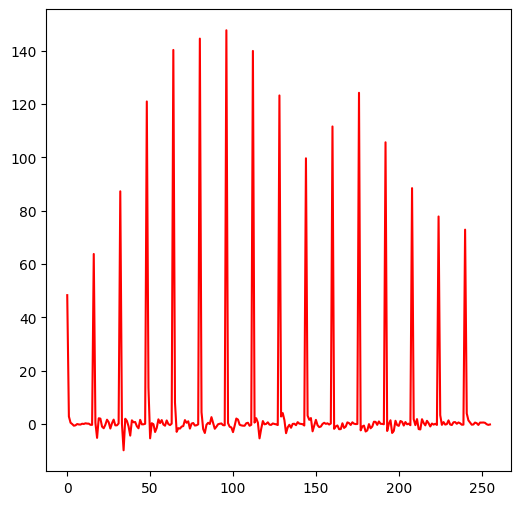

In [111]:
%matplotlib inline


plt.figure(figsize=(6,6))
plt.plot(mfcc,'r')
plt.show()


(16, 16)


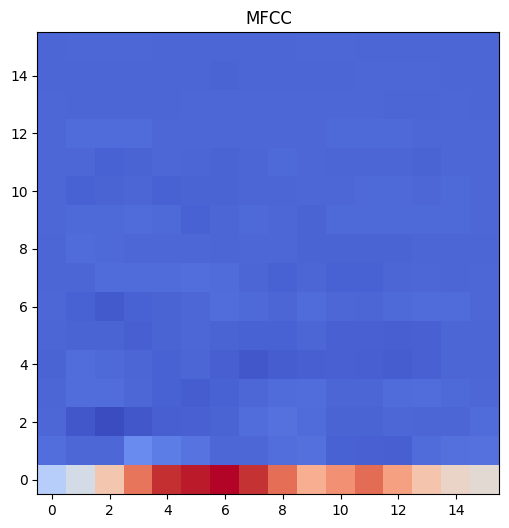

In [112]:
mfcc_from_time_series = mfcc.reshape(16,16)

print(mfcc_from_time_series.shape)

#plt.figure(figsize=(12,12))

fig, ax = plt.subplots(figsize=(6,6))
mfcc_from_time_series= np.swapaxes(mfcc_from_time_series, 0 ,1)
cax = ax.imshow(mfcc_from_time_series, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()

In [113]:
#Change -DFFTXXXX to the desired FFT size
subprocess.run('g++ -Dcomputer compute_mfcc.cpp -o compute_mfcc' , shell=True)  
subprocess.run(["./compute_mfcc"], shell=True)

Freq Sample : 8000
Num Cepstra : 15
Num Filters : 16
FFT   Size  : 1024
Frame Shift : 465
Init Filterbank
Init Twiddle
MFCC_INIT done


CompletedProcess(args=['./compute_mfcc'], returncode=0)

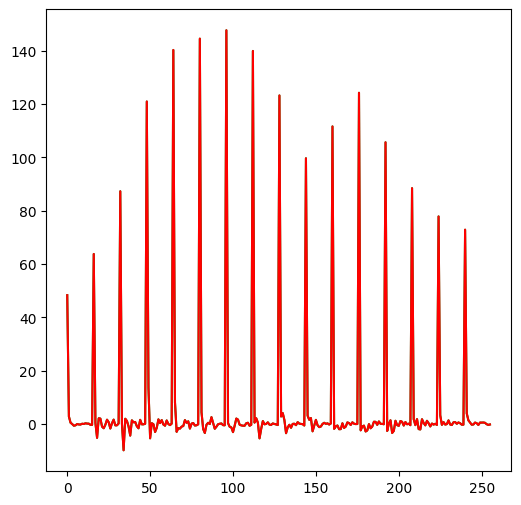

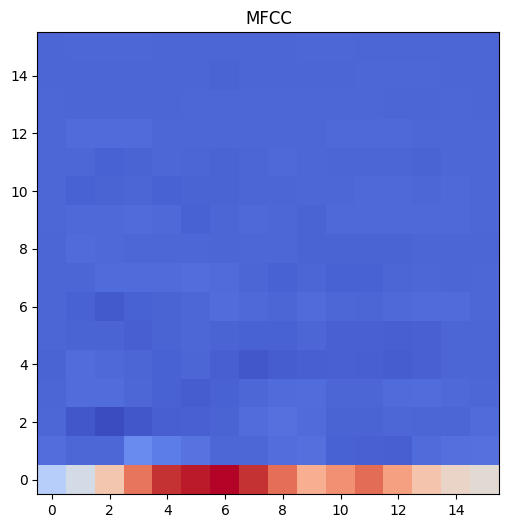

In [114]:

mfcc_from_time_series = np.genfromtxt('mfcc_from_time_series_1s.dat',delimiter='\n',dtype=None)

%matplotlib inline


plt.figure(figsize=(6,6))
# #plt.plot(mfcc_output,'r')

plt.plot(mfcc_from_time_series,'g')
plt.plot(mfcc,'r')

mfcc_from_time_series = mfcc_from_time_series.reshape(16,16)
fig, ax = plt.subplots(figsize=(6,6))
mfcc_from_time_series= np.swapaxes(mfcc_from_time_series, 0 ,1)
cax = ax.imshow(mfcc_from_time_series, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')

plt.show()